# Explore here

It's recommended to use this notebook for exploration purposes.

In [53]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns



In [ ]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
url = 'https://assetmarketcap.com/'
response = requests.get(url, time.sleep(10), headers = header)

if response:
    soup = BeautifulSoup(response.text, 'html')
    table  = soup.find('table')
    rows = table.find_all('tr')

    data = []
    #divide the table into cols
    for i in rows:
        cols = i.find_all('td')
        row_data = []
        for j, col in enumerate(cols):
            if j == 2: #the 'name' column has two strings, we need only main name
                name = col.find('div', class_='Logo_text').find('a') #search for <a> ignores <h4> to get clean names
                row_data.append(name.get_text(strip=True) if name else "")
            else:
                row_data.append(col.get_text(strip=True))
        if row_data:
            data.append(row_data) #dumps info to data list
    

In [55]:
#Create the dataframe with all data
df = pd.DataFrame(data, columns=['none', 'id','Asset', 'Market Cap', 'Price', '24Hr Changing', 'Circulating Supply', 'Type'])
df.head()

,none,id,Asset,Market Cap,Price,24Hr Changing,Circulating Supply,Type
0,,1,Real Estate,"$665,986,398,213,888","$317,157.61",0.34%,"2,099,859,454",Commodity
1,,2,Oil,"$110,708,062,699,036",$61.73,-1.03%,"1,793,424,000,000",Commodity
2,,3,Chinese Yuan,"$46,636,668,894,266",$0.1405,-0.00%,"331,983,140,000,000",Currency
3,,4,Gold,"$26,139,908,738,434","$3,892.50",0.50%,"6,715,455,039",Commodity
4,,5,United States Dollar,"$22,195,400,000,000",$1.00,0.00%,"22,195,400,000,000",Currency


In [56]:
#Cleaning dataframe

df = df.drop('none', axis = 1) #remove none column
df = df.set_index('id') # set id col as index
df['Market Cap'] = df['Market Cap'].str[1:].replace(',', '', regex=True).astype('int64')#removes the $ and commas to clean the value 
df['Price'] = df['Price'].str[1:].replace(',', '', regex=True).astype('float') #same for price and transform into float
df['Circulating Supply'] = df['Circulating Supply'].replace(',', '', regex=True).astype('int64')
df['24Hr Changing'] = df['24Hr Changing'].str[0:-1].astype('float') #removes % symbol
df.head()

,Asset,Market Cap,Price,24Hr Changing,Circulating Supply,Type
id,,,,,,
1,Real Estate,665986398213888,317157.6100,0.34,2099859454,Commodity
2,Oil,110708062699036,61.7300,-1.03,1793424000000,Commodity
3,Chinese Yuan,46636668894266,0.1405,-0.00,331983140000000,Currency
4,Gold,26139908738434,3892.5000,0.50,6715455039,Commodity
5,United States Dollar,22195400000000,1.0000,0.00,22195400000000,Currency


In [57]:
#Store data in SQLite

con = sqlite3.connect('assetmarketcap.db') #create database

cur = con.cursor() #creates the cursor

df.to_sql("assets", con, if_exists="replace", index=False)

res = cur.execute('SELECT * FROM assets LIMIT 3;')  #testing the new database
res.fetchall()



[('Real Estate', 665986398213888, 317157.61, 0.34, 2099859454, 'Commodity'),
 ('Oil', 110708062699036, 61.73, -1.03, 1793424000000, 'Commodity'),
 ('Chinese Yuan', 46636668894266, 0.1405, 0.0, 331983140000000, 'Currency')]

In [58]:
con.commit() #commit the treansaction 
con.close() #closing connection

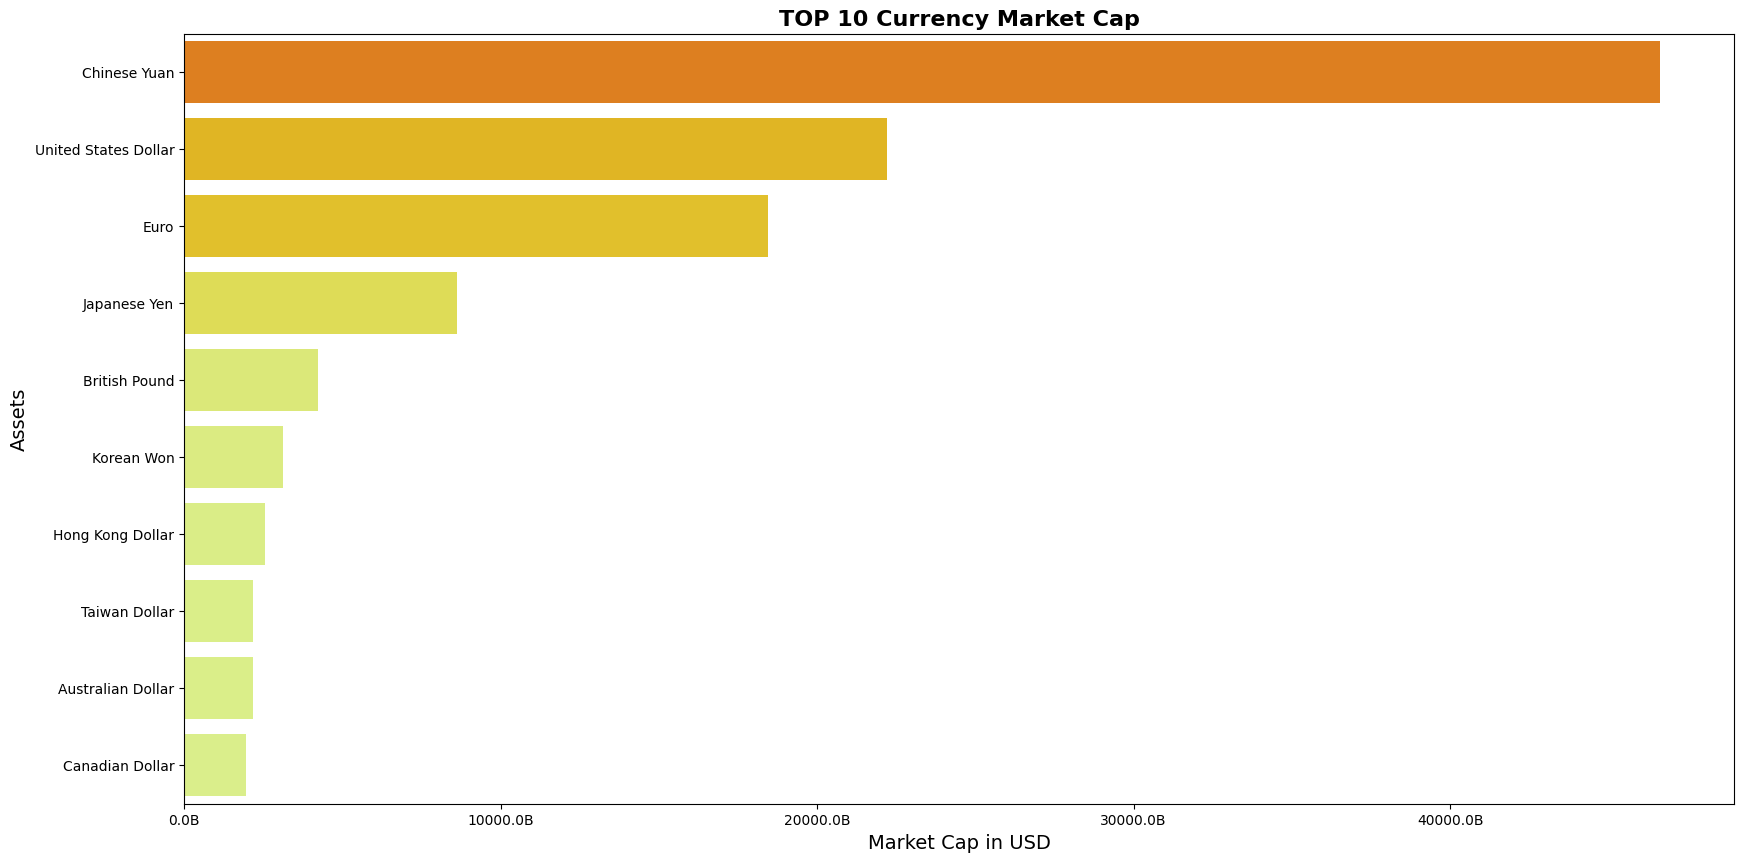

In [59]:
#visualizations
#Top Currencies by market cap

top_currencies = df[df['Type'] == 'Currency'].iloc[:10] #Get only currency values
y = top_currencies['Asset'] # Currencys name
x = top_currencies['Market Cap'] # Currencys Market Cap

plt.figure(figsize=(20,10))
sns.barplot(x = x, y = y, hue = x, palette = 'Wistia', legend= False)
plt.title('TOP 10 Currency Market Cap', fontsize = 16, fontweight = 'bold')
plt.ylabel('Assets', fontsize = 14)
plt.xlabel('Market Cap in USD', fontsize = 14)

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.1f}B')) #sets the x axis in American Bilions

plt.show()

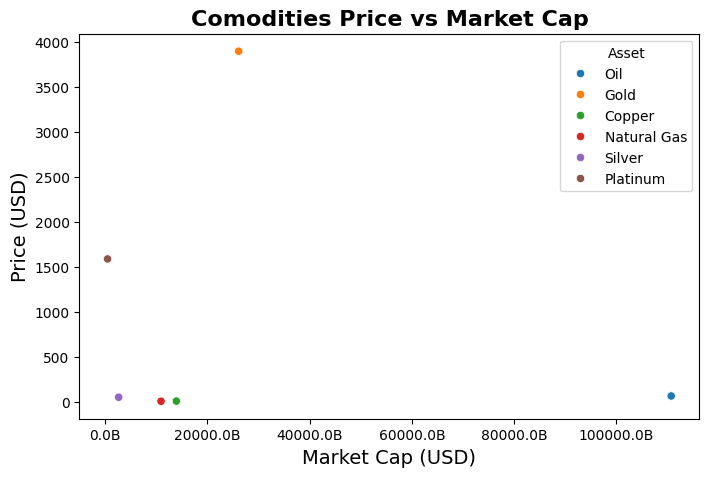

In [60]:
# Commodities Prices vs Market Cap

df = df[df['Type'] == 'Commodity'].iloc[1:]

plt.figure(figsize=(8,5))
sns.scatterplot(data = df, x = df['Market Cap'], y = df['Price'], hue=df['Asset'], sizes = 40)
plt.title('Comodities Price vs Market Cap', fontsize = 16, fontweight = 'bold')
plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Market Cap (USD)', fontsize = 14)

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.1f}B')) #sets the x axis in American Bilions

plt.show()